# Prepare Data


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd
import pickle
import gzip
import time
from tqdm import tqdm
import seaborn as sns
from scipy.stats import moment, kurtosis, skew
from scipy.ndimage import gaussian_filter1d

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from matplotlib.backends.backend_pdf import PdfPages


import torch
from torch import nn
from torch.optim import Adam

import xgboost as xgb


Load as many dictionaries with different enrgies as you want

In [2]:
data_path_1 = '/kaggle/input/dct-au-19/DICT_Au_19.dat'
with open(data_path_1, "rb") as pf:
    Data_19 = pickle.load(pf)
    
data_path_2 = '/kaggle/input/dct-au-200/DICT_Au_200.dat'
with open(data_path_2, "rb") as pf:
    Data_200 = pickle.load(pf)

In [3]:
#Data1['Au']['0-10']

Append all the dictionaries 

In [4]:
Dcts = []
Dcts.append(Data_19)
Dcts.append(Data_200)

In [5]:
def load(Dct, Nuc, cent, charge, Ncurve = -1):
    #Dct = Data
    Yin = Dct[Nuc][cent][charge]["INITIAL"]
    Yfin = Dct[Nuc][cent][charge]["FINAL"]
    Yfin_netp = Dct[Nuc][cent]['netp']["FINAL"]
    Yfin_netn = Dct[Nuc][cent]['netn']["FINAL"]
    Yfin_p = Dct[Nuc][cent]['p']["FINAL"]
    Yfin_n = Dct[Nuc][cent]['n']["FINAL"]
    Xin = Dct[Nuc]["INITIAL_eta"] 
    Xfin = Dct[Nuc]["FINAL_eta"] 
    return Xin, Yin, Xfin, Yfin, Yfin_netp, Yfin_netn, Yfin_p, Yfin_n

In [6]:
def load_sample(Dct, Nuc, cent, charge, Ncurve=2000):
    #Dct = Data
    Yin = Dct[Nuc][cent][charge]["INITIAL"][:Ncurve]
    Yfin = Dct[Nuc][cent][charge]["FINAL"][:Ncurve]
    Xin = Dct[Nuc]["INITIAL_eta"] 
    Xfin = Dct[Nuc]["FINAL_eta"] 
    return Xin, Yin, Xfin, Yfin

In [7]:
Xin_Au = Data_19['Au']['INITIAL_eta']
Xfin_Au = Data_19['Au']['FINAL_eta']

xaxes1 = Xin_Au
xaxes2 = Xfin_Au

#Xin_Zr = Data['Zr']['INITIAL_eta']
#Xfin_Zr = Data['Zr']['FINAL_eta']

Moments

Defined a function to print moments for a prediction

In [8]:
def calculate_moments_cumulants(data):
    mean = np.mean(data)
    variance = np.var(data)
    third_moment = np.mean((data - mean) ** 3)
    fourth_moment = np.mean((data - mean) ** 4)
    
    moments = {
        'mean': mean,
        'variance': variance,
        'third_moment': third_moment,
        'fourth_moment': fourth_moment
    }
    
    cumulants = {
        'mean': mean,
        'variance': variance,
        'third_cumulant': third_moment ,
        'fourth_cumulant': fourth_moment - 3 * ((variance) ** 2)
    }
    
    return moments, cumulants

Finetune

Defined a function that can be used to finetune(train) any model

In [9]:
# Initialize PdfPages globally
pdf_pages = PdfPages('plots.pdf')

def finetune(model, X_train, y_train, X_test, y_test, flag=False, scale=False):
    start_time = time.time()
    #if model == lr:
        #plt_title = 'Linear Regression'
    #elif model == mlp:
       # plt_title = 'MLP'
    #else:
        #plt_title = 'Misc'
    
    if flag:
        model.fit(X_train[:, :72], y_train)
        y_pred = model.predict(X_test[:, :72])
    else:
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        #for i in range(10):
            #y_pred_ = model.predict(X_test)
            
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Training completed in {elapsed_time:.2f} seconds.")

    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")

    sample_index = np.random.randint(1, len(X_test))
    y1_plot = X_test[sample_index, :72]
    y1 = X_test[sample_index]
    y2 = y_test[sample_index]

    xaxes1 = Xin_Au
    xaxes2 = Xfin_Au

    if flag:
        y1 = y1[:72]
        y2_pred = model.predict([y1])[0]
    else:
        
        y2_pred = model.predict([y1])[0]
        initial = sum(y1[:72])
        final_pred = sum(y2[:141])
        final_actual = sum(y2_pred[:141])
        print(len(y2_pred))

        plt.plot(xaxes1, y1_plot, 'r', label='Initial')
        plt.plot(xaxes2, y2[:141], 'b', label='Final')
        plt.plot(xaxes2, y2_pred[:141], 'k', label='Predicted')
        plt.xlabel(r'$\eta_s, \eta$')
        plt.ylabel(r'$\rho_B, \frac{dN_B}{d\eta}$')
        plt.legend()
        #plt.title('Prediction for: '+ plt_title)

        # Save current plot to the PdfPages object
        #pdf_pages.savefig()
        plt.show()
        
        print('initial:',initial /71 * (max(xaxes1) - min(xaxes1)))
        print('final_pred: ', final_pred / 140 * (max(xaxes2) - min(xaxes2)))
        print('final_actual: ',final_actual / 140 * (max(xaxes2) - min(xaxes2)))
            

# Function to close the PdfPages object
def close_pdf():
    pdf_pages.close()
    print("PDF file closed.")

#
# close_pdf()


Histograms

Once the model has been finetuned using the above function, we can test the perfroamce on test data to plot histograms

In [10]:
# Define your model
# lr2 = LinearRegression()
verbose = True

# Plotting function for histograms
def plot_histograms(model, X_test, y_test, all_cent_test, all_charge_test, flag=False):
    # Charge labels
    charge_labels = ['B', 'Q']
    check = 0
    # Centrality ranges
    cent_ranges = ['0-10', '10-20', '20-40', '40-60', '60-80']

    # Decode one-hot encoded centrality and charge labels

    all_cent_test_decoded = cent_one_hot_encoder.inverse_transform(all_cent_test)

    all_charge_test_decoded = charge_one_hot_encoder.inverse_transform(all_charge_test)

    for cent_range in cent_ranges:
        plt.figure(figsize=(12, 6))
        plt.suptitle(f'{cent_range} : Overlapping Histogram of Integration Ranges')

        for i, charge_type in enumerate(charge_labels):
            cent_Yin = []
            cent_Yfin = []

            # Iterate through the test data
            for j in range(X_test.shape[0]):
                Yin = X_test[j]
                Yfin = y_test[j]

                # Extract decoded values
                cent_decoded = all_cent_test_decoded[j][0]
                charge_decoded = all_charge_test_decoded[j][0]

                # Check if the current sample belongs to the current centrality range and charge type
                if (cent_decoded == cent_range) and (charge_decoded == charge_type):
                    cent_Yin.append(Yin)
                    cent_Yfin.append(Yfin)

            if not cent_Yin or not cent_Yfin:
                continue

            cent_Yin = np.array(cent_Yin)
            cent_Yfin = np.array(cent_Yfin)

            x_range_min = -0.8
            x_range_max = 0.8

            # Find indices where x-axis values are within the specified range
            indices = np.where((Xfin_Ru >= x_range_min) & (Xfin_Ru <= x_range_max))[0]
            indices2 = np.where((Xin_Ru >= x_range_min) & (Xin_Ru <= x_range_max))[0]
            integration_range_pred = []
            integration_range_actual = []
            integration_range_initial = []

            check += len(cent_Yin)
            for k in range(len(cent_Yin)):
                y1 = cent_Yin[k]
                if flag:
                    y1 = y1[:72]
                y2 = cent_Yfin[k]
                y2_pred = model.predict([y1])

                # Sum the corresponding values in y2_pred
                integrated_value_pred = np.sum(y2_pred[0][indices])
                integration_range_pred.append(integrated_value_pred)

                integrated_value_actual = np.sum(y2[indices])
                integration_range_actual.append(integrated_value_actual)

                integrated_value_initial = np.sum(y1[indices2])
                integration_range_initial.append(integrated_value_initial)
                verbose = True
                """
                if verbose == True and k == 10:
                # Plotting the graph as before
                    plt.plot(Xin_Ru, y1[:72], 'r')
                    plt.plot(Xfin_Ru, y2, 'b')
                    plt.plot(Xfin_Ru, y2_pred[0], 'k')
                    plt.plot(Xfin_Ru[indices], y2_pred[0][indices], 'g', linewidth = 5, alpha = 0.5) 
                    plt.legend(['Initial', 'Final', 'Predicted', 'Range'])
                    plt.show()
                    verbose = False
                """
            # Calculate moments and cumulants
            moments_pred, cumulants_pred = calculate_moments_cumulants(integration_range_pred)
            moments_actual, cumulants_actual = calculate_moments_cumulants(integration_range_actual)
            """
            print(f'{cent_range} : Moments for {charge_type} Predicted')
            print(moments_pred)
            print(f'{cent_range} : Moments for {charge_type} Actual')
            print(moments_actual)

            print(f'{cent_range} : Cumulants for {charge_type} Predicted')
            print(cumulants_pred)
            print(f'{cent_range} : Cumulants for {charge_type} Actual')
            """
            # Calculate the range of your data
            data_range_pred = max(integration_range_pred) - min(integration_range_pred)
            data_range_actual = max(integration_range_actual) - min(integration_range_actual)

            # Calculate the number of bins of width 0.5 within your data range
            num_bins_pred = int(data_range_pred / 3)
            num_bins_actual = int(data_range_actual / 3)

            plt.subplot(1, 2, i + 1)
            print(i)
            plt.hist(integration_range_pred, bins=num_bins_pred, color='b', alpha=0.5, label='Predicted')
            plt.hist(integration_range_actual, bins=num_bins_actual, color='r', alpha=0.5, label='Actual')
            plt.title(f'Charge: {charge_type}')
            plt.xlabel('Integrated Value')
            plt.ylabel('Frequency')
            plt.legend()
            plt.grid(True)

            print("actual", len(integration_range_actual))
            print("pred", len(integration_range_pred))

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
        print("X_test:", len(X_test))
        print("Check:", check)


Error Scatterplots

Same but plotting scatterplots

In [11]:
# Define your model
# lr2 = LinearRegression()
verbose = True

# Plotting function for error norm scatter plots
def plot_error_norm(model, X_test, y_test, all_cent_test, all_charge_test,y_test2,flag=False):
    # Charge labels
    charge_labels = ['B', 'Q']
    check = 0
    
    error_count = 0
    # Centrality ranges
    cent_ranges = ['0-10', '10-20', '20-40', '40-60', '60-80']

    # Decode one-hot encoded centrality and charge labels
    all_cent_test_decoded = cent_one_hot_encoder.inverse_transform(all_cent_test)
    all_charge_test_decoded = charge_one_hot_encoder.inverse_transform(all_charge_test)

    for cent_range in cent_ranges:
        plt.figure(figsize=(12, 6))
        plt.suptitle(f'{cent_range} : Normalized Error Scatter Plot')
        error_count_cent = 0

        for i, charge_type in enumerate(charge_labels):
            cent_Yin = []
            cent_Yfin = []
            cent_Yfin_actual = []

            # Iterate through the test data
            for j in range(X_test.shape[0]):
                Yin = X_test[j]
                Yfin = y_test[j]
                Yfin2 = y_test2[j]

                # Extract decoded values
                cent_decoded = all_cent_test_decoded[j][0]
                charge_decoded = all_charge_test_decoded[j][0]

                # Check if the current sample belongs to the current centrality range and charge type
                if (cent_decoded == cent_range) and (charge_decoded == charge_type):
                    cent_Yin.append(Yin)
                    cent_Yfin.append(Yfin)
                    cent_Yfin_actual.append(Yfin2)


            if not cent_Yin or not cent_Yfin:
                continue

            cent_Yin = np.array(cent_Yin)
            cent_Yfin = np.array(cent_Yfin)
            cent_Yfin_actual = np.array(cent_Yfin_actual)

            x_range_min = -0.8
            x_range_max = 0.8

            # Find indices where x-axisvalues are within the specified range
            indices = np.where((Xfin_Au >= x_range_min) & (Xfin_Au <= x_range_max))[0]
            indices2 = np.where((Xin_Au >= x_range_min) & (Xin_Au <= x_range_max))[0]
            std_dev_actual = []
            error_norm = []

            check += len(cent_Yin)
            plot_check = 0
            for k in range(len(cent_Yin)):#iterating the test data
                y1 = cent_Yin[k]#one event in the test data
                if flag:
                    y1 = y1[:72]
                y2 = cent_Yfin[k]
                y2_f = cent_Yfin_actual[k]#actual final state of the event
                y2_pred = model.predict([y1])#predicted final state of the event

                integrated_value_pred = np.sum(y2_pred[0][indices]) / len(y2_pred[0][indices])#sum of preds
                integrated_value_actual = np.sum(y2_f[indices])/len(y2_pred[0][indices])#sum of actual
                std_dev = np.std(y2_f[indices])
                std_dev_actual.append(std_dev)#std of actual
                error = (integrated_value_pred - integrated_value_actual) / std_dev#error
                error_norm.append(error)#list of errors for all the events
                
                
                if abs(error) > 1:
                     error_count_cent += 1
                """
                    plot_check += 1
                    print(y1[-4], y1[-3])
                    # Example x-axis values
                    if y1[-3] == 0.0 and y1[-4] == 1.0:
                        xaxes1 = Xin_Ru
                        xaxes2 = Xfin_Ru
                        print('Ru')
                    else:
                        xaxes1 = Xin_Zr
                        xaxes2 = Xfin_Zr
                        print('Zr')
                    #print(xaxes1, xaxes2)
                    if flag:
                        y1 = y1[:72]
                        y2_pred = model.predict([y1])[0]
                    else:
                        y2_pred = model.predict([y1])[0]

                    # Plotting
                    plt.figure(figsize = (5,5))
                    plt.plot(xaxes1, y1[:72], 'r', label='Initial')
                    plt.plot(xaxes2, y2, 'b', label='Final')
                    plt.plot(xaxes2, y2_pred, 'k', label='Predicted')
                    plt.plot(xaxes2[indices], y2_pred[indices], 'g', linewidth = 4, alpha = 0.5)
                    plt.plot(xaxes2[indices], y2[indices], 'y', linewidth = 4, alpha = 0.5)
                    plt.legend()
                    plt.xlabel('X-axis label') 
                    plt.ylabel('Y-axis label')  
                    if plot_check < 3:
                        plt.show()
                """

                verbose = True

            # Scatter plot for normalized errors
            plt.subplot(1, 2, i + 1)
            plt.scatter(range(len(error_norm)), error_norm, alpha=0.5, label=f'Error Norm {charge_type}')
            #plt.hist(error_norm, alpha=0.5, density = True)
            plt.title(f'Normalized Errors for {charge_type}')
            plt.xlabel('Event Index')
            plt.ylabel('Normalized Error')
            plt.legend()
            plt.grid(True)
            error_count +=  error_count_cent

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
        print("X_test:", len(X_test))
        print("Check:", check)
        print("Total >1 std dev:", error_count_cent)
        
    print("Total >1 std dev:", error_count)

# Example usage of the function
# Assuming cent_one_hot_encoder, charge_one_hot_encoder, X_test, y_test, all_cent_test, and all_charge_test are defined
#plot_error_norm(lr2, X_test, y_test, all_cent_test, all_charge_test)

#plot_error_norm(lr, X_test_1, y_test_1, all_cent_test_1, all_charge_test_1)



Histograms

Same plots for transformer model

In [12]:
def plot_histograms_nn(model, X_test, y_test, all_cent_test, all_charge_test, flag=False):
    # Charge labels
    charge_labels = ['B', 'Q']
    check = 0
    # Centrality ranges
    cent_ranges = ['0-10', '10-20', '20-40', '40-60', '60-80']

    # Decode one-hot encoded centrality and charge labels
    all_cent_test_decoded = cent_one_hot_encoder.inverse_transform(all_cent_test)
    all_charge_test_decoded = charge_one_hot_encoder.inverse_transform(all_charge_test)

    for cent_range in cent_ranges:
        plt.figure(figsize=(12, 6))
        plt.suptitle(f'{cent_range} : Overlapping Histogram of Integration Ranges')

        for i, charge_type in enumerate(charge_labels):
            cent_Yin = []
            cent_Yfin = []

            # Iterate through the test data
            for j in range(X_test.shape[0]):
                Yin = X_test[j]
                Yfin = y_test[j]

                # Extract decoded values
                cent_decoded = all_cent_test_decoded[j][0]
                charge_decoded = all_charge_test_decoded[j][0]

                # Check if the current sample belongs to the current centrality range and charge type
                if (cent_decoded == cent_range) and (charge_decoded == charge_type):
                    cent_Yin.append(Yin)
                    cent_Yfin.append(Yfin)

            if not cent_Yin or not cent_Yfin:
                continue

            cent_Yin = np.array(cent_Yin)
            cent_Yfin = np.array(cent_Yfin)

            x_range_min = -0.8
            x_range_max = 0.8

            # Find indices where x-axis values are within the specified range
            indices = np.where((Xfin_Ru >= x_range_min) & (Xfin_Ru <= x_range_max))[0]
            indices2 = np.where((Xin_Ru >= x_range_min) & (Xin_Ru <= x_range_max))[0]
            integration_range_pred = []
            integration_range_actual = []
            integration_range_initial = []

            check += len(cent_Yin)
            for k in range(len(cent_Yin)):
                y1 = cent_Yin[k]
                if flag:
                    y1 = y1[:72]
                y2 = cent_Yfin[k]

                # Prepare the input for the model
                y1_tensor = torch.FloatTensor([y1]).to(device)
                model.eval()
                with torch.no_grad():
                    y2_pred_tensor = model(y1_tensor)
                y2_pred = y2_pred_tensor.cpu().numpy()

                # Sum the corresponding values in y2_pred
                integrated_value_pred = np.sum(y2_pred[0][indices])
                integration_range_pred.append(integrated_value_pred)

                integrated_value_actual = np.sum(y2[indices])
                integration_range_actual.append(integrated_value_actual)

                integrated_value_initial = np.sum(y1[indices2])
                integration_range_initial.append(integrated_value_initial)

                verbose = True
                """
                if verbose == True and k == 10:
                # Plotting the graph as before
                    plt.plot(Xin_Ru, y1[:72], 'r')
                    plt.plot(Xfin_Ru, y2, 'b')
                    plt.plot(Xfin_Ru, y2_pred[0], 'k')
                    plt.plot(Xfin_Ru[indices], y2_pred[0][indices], 'g', linewidth = 5, alpha = 0.5) 
                    plt.legend(['Initial', 'Final', 'Predicted', 'Range'])
                    plt.show()
                    verbose = False
                """
            # Calculate moments and cumulants
            moments_pred, cumulants_pred = calculate_moments_cumulants(integration_range_pred)
            moments_actual, cumulants_actual = calculate_moments_cumulants(integration_range_actual)
            """
            print(f'{cent_range} : Moments for {charge_type} Predicted')
            print(moments_pred)
            print(f'{cent_range} : Moments for {charge_type} Actual')
            print(moments_actual)

            print(f'{cent_range} : Cumulants for {charge_type} Predicted')
            print(cumulants_pred)
            print(f'{cent_range} : Cumulants for {charge_type} Actual')
            """
            # Calculate the range of your data
            data_range_pred = max(integration_range_pred) - min(integration_range_pred)
            data_range_actual = max(integration_range_actual) - min(integration_range_actual)

            # Calculate the number of bins of width 3 within your data range
            num_bins_pred = int(data_range_pred / 3)
            num_bins_actual = int(data_range_actual / 3)

            plt.subplot(1, 2, i + 1)
            print(i)
            plt.hist(integration_range_pred, bins=num_bins_pred, color='b', alpha=0.5, label='Predicted')
            plt.hist(integration_range_actual, bins=num_bins_actual, color='r', alpha=0.5, label='Actual')
            plt.title(f'Charge: {charge_type}')
            plt.xlabel('Integrated Value')
            plt.ylabel('Frequency')
            plt.legend()
            plt.grid(True)

            print("actual", len(integration_range_actual))
            print("pred", len(integration_range_pred))

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
        print("X_test:", len(X_test))
        print("Check:", check)

# Example usage of the function
# Assuming cent_one_hot_encoder, charge_one_hot_encoder, X_test, y_test, all_cent_test, and all_charge_test are defined



Error Scatterplots

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

# Plotting function for error norm scatter plots
def plot_error_norm_nn(model, X_test, y_test, all_cent_test, all_charge_test , flag=False):
    # Charge labels
    charge_labels = ['B', 'Q']
    check = 0
    
    error_count = 0
    # Centrality ranges
    cent_ranges = ['0-10', '10-20', '20-40', '40-60', '60-80']

    # Decode one-hot encoded centrality and charge labels
    all_cent_test_decoded = cent_one_hot_encoder.inverse_transform(all_cent_test)
    all_charge_test_decoded = charge_one_hot_encoder.inverse_transform(all_charge_test)

    for cent_range in cent_ranges:
        plt.figure(figsize=(12, 6))
        plt.suptitle(f'{cent_range} : Normalized Error Scatter Plot')
        error_count_cent = 0

        for i, charge_type in enumerate(charge_labels):
            cent_Yin = []
            cent_Yfin = []

            # Iterate through the test data
            for j in range(X_test.shape[0]):
                Yin = X_test[j]
                Yfin = y_test[j]

                # Extract decoded values
                cent_decoded = all_cent_test_decoded[j][0]
                charge_decoded = all_charge_test_decoded[j][0]

                # Check if the current sample belongs to the current centrality range and charge type
                if (cent_decoded == cent_range) and (charge_decoded == charge_type):
                    cent_Yin.append(Yin)
                    cent_Yfin.append(Yfin)

            if not cent_Yin or not cent_Yfin:
                continue

            cent_Yin = np.array(cent_Yin)
            cent_Yfin = np.array(cent_Yfin)

            x_range_min = -0.8
            x_range_max = 0.8

            # Find indices where x-axis values are within the specified range
            indices = np.where((Xfin_Ru >= x_range_min) & (Xfin_Ru <= x_range_max))[0]
            indices2 = np.where((Xin_Ru >= x_range_min) & (Xin_Ru <= x_range_max))[0]
            std_dev_actual = []
            error_norm = []

            check += len(cent_Yin)
            plot_check = 0
            for k in range(len(cent_Yin)):  # Iterating the test data
                y1 = cent_Yin[k]  # One event in the test data
                if flag:
                    y1 = y1[:72]
                y2 = cent_Yfin[k]  # Actual final state of the event

                # Prepare the input for the model
                y1_tensor = torch.FloatTensor([y1]).to(device)
                model.eval()
                with torch.no_grad():
                    y2_pred_tensor = model(y1_tensor)
                y2_pred = y2_pred_tensor.cpu().numpy()  # Predicted final state of the event

                integrated_value_pred = np.sum(y2_pred[0][indices]) / len(y2_pred[0][indices])  # Sum of preds
                integrated_value_actual = np.sum(y2[indices]) / len(y2_pred[0][indices])  # Sum of actual
                std_dev = np.std(y2[indices])
                std_dev_actual.append(std_dev)  # Std of actual
                error = (integrated_value_pred - integrated_value_actual) / std_dev  # Error
                error_norm.append(error)  # List of errors for all the events

                if abs(error) > 1:
                    error_count_cent += 1

            # Scatter plot for normalized errors
            plt.subplot(1, 2, i + 1)
            plt.scatter(range(len(error_norm)), error_norm, alpha=0.5, label=f'Error Norm {charge_type}')
            plt.title(f'Normalized Errors for {charge_type}')
            plt.xlabel('Event Index')
            plt.ylabel('Normalized Error')
            plt.legend()
            plt.grid(True)
            error_count += error_count_cent

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
        print("X_test:", len(X_test))
        print("Check:", check)
        print("Total >1 std dev:", error_count_cent)

    print("Total >1 std dev:", error_count)

# Example usage of the function
# Assuming cent_one_hot_encoder, charge_one_hot_encoder, X_test, y_test, all_cent_test, and all_charge_test are defined



This cell will prepare all the different datasets and also d energies.

In [14]:
# Initialize lists to store Yin, Yfin, Xin, Xfin, Nuc, cent, and charge
all_Yin_B = []
all_Yin_Q = []
all_Yfin_B = []
all_Yfin_Q = []
Yfin_netp_B = []
Yfin_netp_Q = []
Yfin_netn_B = []
Yfin_netn_Q = []
Yfin_p_B = []
Yfin_p_Q = []
Yfin_n_B = []
Yfin_n_Q = []

ch = set()

# Iterate through the dictionaries
for idx, Data in enumerate(Dcts):
    # Iterate through the dictionary
    for Nuc, cent_dict in Data.items():
        for cent, charge_dict in cent_dict.items():
            if isinstance(charge_dict, dict):
                for charge, data_dict in charge_dict.items():
                    if isinstance(data_dict, dict) and "INITIAL" in data_dict and "FINAL" in data_dict:
                        # Load Xin, Yin, Xfin, Yfin using the load function
                        Xin, Yin, Xfin, Yfin, Yfin_netp, Yfin_netn, Yfin_p, Yfin_n = load(Data, Nuc, cent, charge)
                        ch.add(charge)
                        
                        # Append 19 for the first dictionary and 200 for the second
                        if idx == 0:
                            Yin = np.hstack((Yin, np.full((Yin.shape[0], 1), 19)))
                        elif idx == 1:
                            Yin = np.hstack((Yin, np.full((Yin.shape[0], 1), 200)))
                        
                        # Depending on the charge, append to respective lists
                        if charge == 'B':
                            all_Yin_B.append(Yin)
                            all_Yfin_B.append(Yfin)
                            Yfin_netp_B.append(Yfin_netp)
                            Yfin_netn_B.append(Yfin_netn)
                            Yfin_p_B.append(Yfin_p)
                            Yfin_n_B.append(Yfin_n)
                        
                        elif charge == 'Q':
                            all_Yin_Q.append(Yin)
                            all_Yfin_Q.append(Yfin)
                            Yfin_netp_Q.append(Yfin_netp)
                            Yfin_netn_Q.append(Yfin_netn)
                            Yfin_p_Q.append(Yfin_p)
                            Yfin_n_Q.append(Yfin_n)

# Convert lists to numpy arrays
all_Yin_B = np.concatenate(all_Yin_B, axis=0)
all_Yfin_B = np.concatenate(all_Yfin_B, axis=0)
Yfin_netp_B = np.concatenate(Yfin_netp_B, axis=0)
Yfin_netn_B = np.concatenate(Yfin_netn_B, axis=0)
Yfin_p_B = np.concatenate(Yfin_p_B, axis=0)
Yfin_n_B = np.concatenate(Yfin_n_B, axis=0)

all_Yin_Q = np.concatenate(all_Yin_Q, axis=0)
all_Yfin_Q = np.concatenate(all_Yfin_Q, axis=0)
Yfin_netp_Q = np.concatenate(Yfin_netp_Q, axis=0)
Yfin_netn_Q = np.concatenate(Yfin_netn_Q, axis=0)
Yfin_p_Q = np.concatenate(Yfin_p_Q, axis=0)
Yfin_n_Q = np.concatenate(Yfin_n_Q, axis=0)

# Split data into training and testing sets for charge 'B'
X_train_B, X_test_B, Y_train_B, Y_test_B = train_test_split(all_Yin_B, all_Yfin_B, test_size=0.2, random_state=42, shuffle=True)
_, _, Yfin_netp_train_B, Yfin_netp_test_B = train_test_split(all_Yin_B, Yfin_netp_B, test_size=0.2, random_state=42, shuffle=True)
_, _, Yfin_netn_train_B, Yfin_netn_test_B = train_test_split(all_Yin_B, Yfin_netn_B, test_size=0.2, random_state=42, shuffle=True)
_, _, Yfin_p_train_B, Yfin_p_test_B = train_test_split(all_Yin_B, Yfin_p_B, test_size=0.2, random_state=42, shuffle=True)
_, _, Yfin_n_train_B, Yfin_n_test_B = train_test_split(all_Yin_B, Yfin_n_B, test_size=0.2, random_state=42, shuffle=True)

# Split data into training and testing sets for charge 'Q'
X_train_Q, X_test_Q, Y_train_Q, Y_test_Q = train_test_split(all_Yin_Q, all_Yfin_Q, test_size=0.2, random_state=42, shuffle=True)
_, _, Yfin_netp_train_Q, Yfin_netp_test_Q = train_test_split(all_Yin_Q, Yfin_netp_Q, test_size=0.2, random_state=42, shuffle=True)
_, _, Yfin_netn_train_Q, Yfin_netn_test_Q = train_test_split(all_Yin_Q, Yfin_netn_Q, test_size=0.2, random_state=42, shuffle=True)
_, _, Yfin_p_train_Q, Yfin_p_test_Q = train_test_split(all_Yin_Q, Yfin_p_Q, test_size=0.2, random_state=42, shuffle=True)
_, _, Yfin_n_train_Q, Yfin_n_test_Q = train_test_split(all_Yin_Q, Yfin_n_Q, test_size=0.2, random_state=42, shuffle=True)

# Apply Gaussian smoothing to Y_train and Y_test for all variants
sigma = 3

def apply_smoothing(y_train_1, y_test_1, sigma):
    y_train_2 = []
    y_test_2 = []
    threshold_train = len(y_train_1) / 2
    threshold_test = len(y_test_1) / 2

    for y in y_train_1:
        y_smoothed = gaussian_filter1d(y, sigma)
        if threshold_train > 0:
            y_train_2.append(y_smoothed)
            #threshold_train -= 1
        else:
            y_train_2.append(y)

    for y in y_test_1:
        y_smoothed = gaussian_filter1d(y, sigma)
        if threshold_test > 0:
            y_test_2.append(y_smoothed)
            #threshold_test -= 1
        else:
            y_test_2.append(y)
    
    return np.array(y_train_2), np.array(y_test_2)

# Apply smoothing to all Y_train and Y_test datasets for B charge
Y_train_B, Y_test_B = apply_smoothing(Y_train_B, Y_test_B, sigma)
Y_train_netp, Y_test_netp = apply_smoothing(Yfin_netp_train_B, Yfin_netp_test_B, sigma)
Y_train_netn, Y_test_netn = apply_smoothing(Yfin_netn_train_B, Yfin_netn_test_B, sigma)
Y_train_p, Y_test_p = apply_smoothing(Yfin_p_train_B, Yfin_p_test_B, sigma)
Y_train_n, Y_test_n = apply_smoothing(Yfin_n_train_B, Yfin_n_test_B, sigma)

# Apply smoothing to all Y_train and Y_test datasets for Q charge
Y_train_Q, Y_test_Q = apply_smoothing(Y_train_Q, Y_test_Q, sigma)
Yfin_netp_train_Q, Yfin_netp_test_Q = apply_smoothing(Yfin_netp_train_Q, Yfin_netp_test_Q, sigma)
Yfin_netn_train_Q, Yfin_netn_test_Q = apply_smoothing(Yfin_netn_train_Q, Yfin_netn_test_Q, sigma)
Yfin_p_train_Q, Yfin_p_test_Q = apply_smoothing(Yfin_p_train_Q, Yfin_p_test_Q, sigma)
Yfin_n_train_Q, Yfin_n_test_Q = apply_smoothing(Yfin_n_train_Q, Yfin_n_test_Q, sigma)

# Now you have X_train_B, X_train_Q and corresponding Y_train and Y_test datasets for each of the Y variants with Gaussian smoothing applied
print("Shape of X_train_B:", X_train_B.shape)
print("Shape of Y_train_B (smoothed):", Y_train_B.shape)
print("Shape of Yfin_netp_train_B (smoothed):", Yfin_netp_train_B.shape)
print("Shape of Yfin_netn_train_B (smoothed):", Yfin_netn_train_B.shape)
print("Shape of Yfin_p_train_B (smoothed):", Yfin_p_train_B.shape)
print("Shape of Yfin_n_train_B (smoothed):", Yfin_n_train_B.shape)

print("Shape of X_train_Q:", X_train_Q.shape)
print("Shape of Y_train_Q (smoothed):", Y_train_Q.shape)
print("Shape of Yfin_netp_train_Q (smoothed):", Yfin_netp_train_Q.shape)
print("Shape of Yfin_netn_train_Q (smoothed):", Yfin_netn_train_Q.shape)
print("Shape of Yfin_p_train_Q (smoothed):", Yfin_p_train_Q.shape)
print("Shape of Yfin_n_train_Q (smoothed):", Yfin_n_train_Q.shape)


Shape of X_train_B: (12767, 73)
Shape of Y_train_B (smoothed): (12767, 141)
Shape of Yfin_netp_train_B (smoothed): (12767, 141)
Shape of Yfin_netn_train_B (smoothed): (12767, 141)
Shape of Yfin_p_train_B (smoothed): (12767, 141)
Shape of Yfin_n_train_B (smoothed): (12767, 141)
Shape of X_train_Q: (12767, 73)
Shape of Y_train_Q (smoothed): (12767, 141)
Shape of Yfin_netp_train_Q (smoothed): (12767, 141)
Shape of Yfin_netn_train_Q (smoothed): (12767, 141)
Shape of Yfin_p_train_Q (smoothed): (12767, 141)
Shape of Yfin_n_train_Q (smoothed): (12767, 141)


A ridge regression model

It's trained on the intital state of Baryon distribution to predict the final state of Baryon too

Training completed in 1.99 seconds.
Mean Squared Error: 0.40259463150295055
141


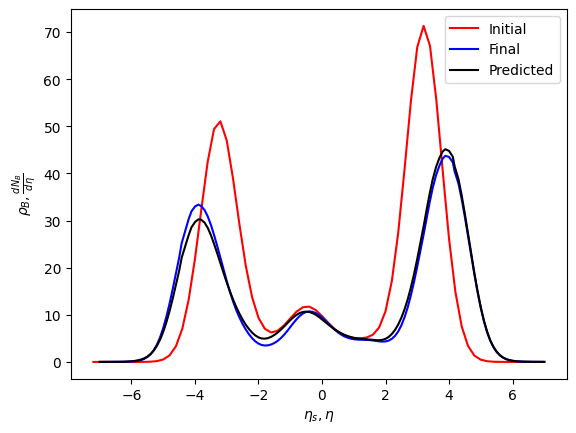

initial: 206.9999232093943
final_pred:  162.94199889182056
final_actual:  165.09870047742572
Model saved to pipeline_B.pkl


In [15]:
# Generate and fit polynomial features with Ridge regression
pipeline_B = make_pipeline(
    PolynomialFeatures(degree=2),
    Ridge(alpha=2.0)
)

# Fit the pipeline to the training data
finetune(pipeline_B, X_train_B, Y_train_B, X_test_B, Y_test_B)
#plot_histograms(pipeline_B, X_test_B, y_test_B, all_cent_test_1, all_charge_test_1)
#plot_error_norm(lr2, X_test_1, y_test_2, all_cent_test_1, all_charge_test_1, y_test_1)

model_path = 'pipeline_B.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(pipeline_B, f)
print(f"Model saved to {model_path}")

It's trained on the intital state of Charge distribution to predict the final state of Charge too

Training completed in 3.25 seconds.
Mean Squared Error: 0.44776387414857394
141


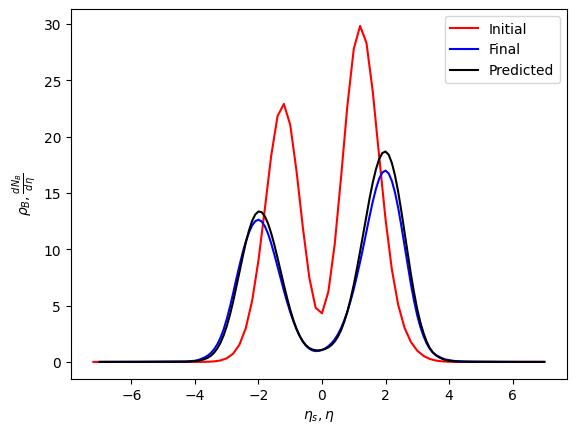

initial: 75.99998070265491
final_pred:  49.84545609492764
final_actual:  52.817404991185676
Model saved to pipeline_Q.pkl


In [16]:
# Generate and fit polynomial features with Ridge regression
pipeline_Q = make_pipeline(
    PolynomialFeatures(degree=2),
    Ridge(alpha=3)
)

from sklearn.utils import shuffle
# Concatenate the training data
X_train_BQ = np.concatenate((X_train_Q, X_train_B), axis=0)
Y_train_BQ = np.concatenate((Y_train_Q, Y_train_B), axis=0)
# Shuffle the data
X_train_BQ, Y_train_BQ = shuffle(X_train_BQ, Y_train_BQ, random_state=42)
# Fit the pipeline to the training data
finetune(pipeline_Q, X_train_BQ, Y_train_BQ, X_test_Q, Y_test_Q)
#finetune(pipeline_Q, X_train_B, Y_train_B, X_test_Q, Y_test_Q)
#plot_histograms(lr2, X_test_1, y_test_2, all_cent_test_1, all_charge_test_1)
#plot_error_norm(lr2, X_test_1, y_test_2, all_cent_test_1, all_charge_test_1, y_test_1)
model_path = 'pipeline_Q.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(pipeline_Q, f)
print(f"Model saved to {model_path}")

It's trained on the intital state of Baryon distribution to predict the final net proton distribution

Training completed in 1.88 seconds.
Mean Squared Error: 0.10868935579585771
141


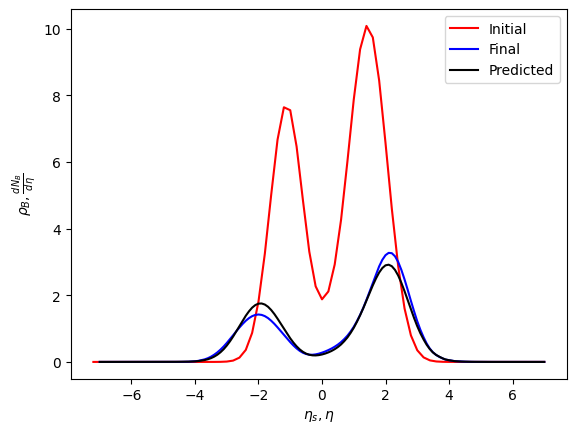

initial: 25.99998196508667
final_pred:  8.40703911807138
final_actual:  8.244463340047835
Model saved to pipeline_B_netp.pkl


In [17]:
# Generate and fit polynomial features with Ridge regression
pipeline_B_netp = make_pipeline(
    PolynomialFeatures(degree=2),
    Ridge(alpha=2.0)
)

# Fit the pipeline to the training data
finetune(pipeline_B_netp, X_train_B, Y_train_netp, X_test_B, Y_test_netp)
#plot_histograms(lr2, X_test_1, y_test_2, all_cent_test_1, all_charge_test_1)
#plot_error_norm(lr2, X_test_1, y_test_2, all_cent_test_1, all_charge_test_1, y_test_1)

model_path = 'pipeline_B_netp.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(pipeline_B_netp, f)
print(f"Model saved to {model_path}")

It's trained on the intital state of Baryon distribution to predict the final proton distribution too

Training completed in 1.91 seconds.
Mean Squared Error: 0.14067250832778933
141


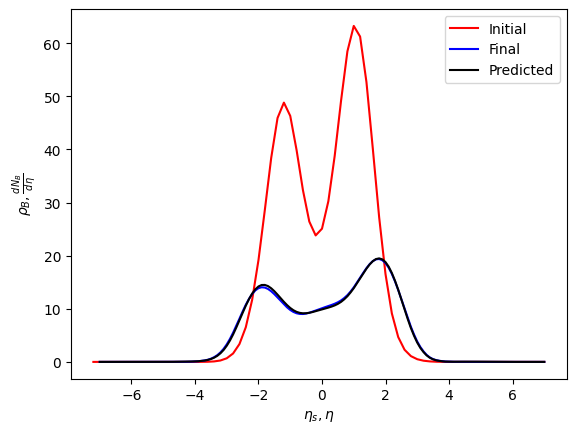

initial: 170.99994072989443
final_pred:  73.86478255568801
final_actual:  73.88213870001515
Model saved to pipeline_B_p.pkl


In [18]:
# Generate and fit polynomial features with Ridge regression
pipeline_B_p = make_pipeline(
    PolynomialFeatures(degree=2),
    Ridge(alpha=2.0)
)

# Fit the pipeline to the training data
#finetune(pipeline_B_p, X_train_B, Yfin_p_train_B, X_test_B, Yfin_p_test_B)
finetune(pipeline_B_p, X_train_B, Y_train_p, X_test_B, Y_test_p)
#plot_histograms(lr2, X_test_1, y_test_2, all_cent_test_1, all_charge_test_1)
#plot_error_norm(lr2, X_test_1, y_test_2, all_cent_test_1, all_charge_test_1, y_test_1)

model_path = 'pipeline_B_p.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(pipeline_B_p, f)
print(f"Model saved to {model_path}")

Class to initialize all the models together and train them

In [19]:
class MultiModelPredictor:
    def __init__(self):
        # Initialize models
        self.pipeline_B = make_pipeline(
            PolynomialFeatures(degree=2),
            Ridge(alpha=2.0)
        )
        
        self.pipeline_Q = make_pipeline(
            PolynomialFeatures(degree=2),
            Ridge(alpha=3)
        )
        
        self.pipeline_B_netp = make_pipeline(
            PolynomialFeatures(degree=2),
            Ridge(alpha=2.0)
        )
        
        self.pipeline_B_p = make_pipeline(
            PolynomialFeatures(degree=2),
            Ridge(alpha=2.0)
        )
        
    def fit(self, X_train_B, Y_train_B, Y_train_netp, Y_train_p,
            X_train_Q, Y_train_Q):
        # Fit the B models
        self.pipeline_B.fit(X_train_B, Y_train_B)
        self.pipeline_B_netp.fit(X_train_B, Y_train_netp)
        self.pipeline_B_p.fit(X_train_B, Y_train_p)
        
        # Fit the Q model
        self.pipeline_Q.fit(X_train_Q, Y_train_Q)
    
    def predict(self, X, model_type='B'):
        if model_type == 'Q':
            return self.pipeline_Q.predict(X)  # Predict with the Q model
        
        elif model_type == 'B':
            # Predict with all three B models and return the results as a tuple
            return (
                self.pipeline_B.predict(X),
                self.pipeline_B_netp.predict(X),
                self.pipeline_B_p.predict(X)
            )
        else:
            raise ValueError(f"Unknown model type: {model_type}")

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self, f)
    
    @classmethod
    def load(cls, filename):
        with open(filename, 'rb') as f:
            return pickle.load(f)

# Example of usage:

# Instantiate the predictor
predictor = MultiModelPredictor()

# Fit the models
predictor.fit(
    X_train_B, Y_train_B, Y_train_netp, Y_train_p,
    X_train_Q, Y_train_Q
)

# Save the model to a file
predictor.save('multi_model_predictor.pkl')

# Load the model from the file
loaded_predictor = MultiModelPredictor.load('multi_model_predictor.pkl')

# Make predictions
X_test_B_example = X_test_B  # Replace with actual data
X_test_Q_example = X_test_Q  # Replace with actual data

# Predict for B input
y_pred_B, y_pred_B_netp, y_pred_B_p = loaded_predictor.predict(X_test_B_example, model_type='B')

# Predict for Q input
y_pred_Q = loaded_predictor.predict(X_test_Q_example, model_type='Q')

#print(y_pred_B,y_pred_Q, y_pred_B_netp, y_pred_B_p)

# y_pred_B, y_pred_B_netp, and y_pred_B_p will contain predictions for the B models
# y_pred_Q will contain predictions for the Q model


In [20]:
class PredictorFromFile:
    def __init__(self, model_file):
        """
        Initialize by loading the MultiModelPredictor from a .pkl file.
        
        Parameters:
        - model_file: Path to the .pkl file containing the saved MultiModelPredictor.
        """
        with open(model_file, 'rb') as f:
            self.predictor = pickle.load(f)
    
    def predict(self, X, model_type='B'):
        """
        Predict using the loaded MultiModelPredictor.

        Parameters:
        - X: Input data for prediction.
        - model_type: Type of model to use for prediction ('B' or 'Q').

        Returns:
        - Predictions from the selected model.
        """
        return self.predictor.predict(X, model_type)

# Example of usage:

# Initialize the PredictorFromFile with the path to the saved model
predictor_from_file = PredictorFromFile('multi_model_predictor.pkl')

# Prepare test data
X_test_B_example = X_test_B  # Replace with actual data
X_test_Q_example = X_test_Q  # Replace with actual data

# Predict for B input
y_pred_B, y_pred_B_netp, y_pred_B_p = predictor_from_file.predict(X_test_B_example, model_type='B')

# Predict for Q input
y_pred_Q = predictor_from_file.predict(X_test_Q_example, model_type='Q')
#print(y_pred_B,y_pred_Q, y_pred_B_netp, y_pred_B_p)
# y_pred_B, y_pred_B_netp, and y_pred_B_p will contain predictions for the B models
# y_pred_Q will contain predictions for the Q model


TF

In [21]:
# Check if CUDA is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert X and Y data to PyTorch tensors and move to the device

def convert_to_tensor(X_train, Y_train, X_test, Y_test):
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    Y_train_tensor = torch.FloatTensor(Y_train).to(device)
    X_test_tensor = torch.FloatTensor(X_test).to(device)
    Y_test_tensor = torch.FloatTensor(Y_test).to(device)
    return X_train_tensor, Y_train_tensor, X_test_tensor, Y_test_tensor

# Convert all datasets
X_train_B_tensor, Y_train_B_tensor, X_test_B_tensor, Y_test_B_tensor = convert_to_tensor(
    X_train_B, Y_train_B, X_test_B, Y_test_B
)
X_train_Q_tensor, Y_train_Q_tensor, X_test_Q_tensor, Y_test_Q_tensor = convert_to_tensor(
    X_train_Q, Y_train_Q, X_test_Q, Y_test_Q
)
X_train_B_netp_tensor, Yfin_netp_train_B_tensor, X_test_B_netp_tensor, Yfin_netp_test_B_tensor = convert_to_tensor(
    X_train_B, Yfin_netp_train_B, X_test_B, Yfin_netp_test_B
)
X_train_B_p_tensor, Yfin_p_train_B_tensor, X_test_B_p_tensor, Yfin_p_test_B_tensor = convert_to_tensor(
    X_train_B, Yfin_p_train_B, X_test_B, Yfin_p_test_B
)
X_train_B_netn_tensor, Yfin_netn_train_B_tensor, X_test_B_netn_tensor, Yfin_netn_test_B_tensor = convert_to_tensor(
    X_train_B, Yfin_netn_train_B, X_test_B, Yfin_netn_test_B
)
X_train_B_n_tensor, Yfin_n_train_B_tensor, X_test_B_n_tensor, Yfin_n_test_B_tensor = convert_to_tensor(
    X_train_B, Yfin_n_train_B, X_test_B, Yfin_n_test_B
)
X_train_Q_netp_tensor, Yfin_netp_train_Q_tensor, X_test_Q_netp_tensor, Yfin_netp_test_Q_tensor = convert_to_tensor(
    X_train_Q, Yfin_netp_train_Q, X_test_Q, Yfin_netp_test_Q
)
X_train_Q_p_tensor, Yfin_p_train_Q_tensor, X_test_Q_p_tensor, Yfin_p_test_Q_tensor = convert_to_tensor(
    X_train_Q, Yfin_p_train_Q, X_test_Q, Yfin_p_test_Q
)
X_train_Q_netn_tensor, Yfin_netn_train_Q_tensor, X_test_Q_netn_tensor, Yfin_netn_test_Q_tensor = convert_to_tensor(
    X_train_Q, Yfin_netn_train_Q, X_test_Q, Yfin_netn_test_Q
)
X_train_Q_n_tensor, Yfin_n_train_Q_tensor, X_test_Q_n_tensor, Yfin_n_test_Q_tensor = convert_to_tensor(
    X_train_Q, Yfin_n_train_Q, X_test_Q, Yfin_n_test_Q
)


In [22]:
class TransformerRegressor(nn.Module):
    def __init__(self, input_dim, output_dim, nhead=73, num_layers=6, dim_feedforward=1024, dropout=0.1):
        super(TransformerRegressor, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.batch_norm = nn.BatchNorm1d(input_dim)
        self.linear = nn.Linear(input_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x.unsqueeze(0)  # Add batch dimension
        x = self.transformer_encoder(x)
        x = x.squeeze(0)  # Remove batch dimension
        x = self.batch_norm(x)  # Apply batch normalization
        x = self.dropout(x)
        x = self.linear(x)
        return x

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import mean_squared_error

# Ensure using GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class TransformerRegressor(nn.Module):
    def __init__(self, input_dim, output_dim, projection_dim=70, nhead=5, num_layers=6, dim_feedforward=1024, dropout=0.1):
        super(TransformerRegressor, self).__init__()
        
        # Adjust input to projection_dim
        self.projection = nn.Linear(input_dim, projection_dim)
        
        # Transformer setup with adjusted input dimension
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=projection_dim, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        
        self.batch_norm = nn.BatchNorm1d(projection_dim)
        self.linear = nn.Linear(projection_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.projection(x)  # Project input to the new dimension
        x = x.unsqueeze(0)  # Add batch dimension
        x = self.transformer_encoder(x)
        x = x.squeeze(0)  # Remove batch dimension
        x = self.batch_norm(x)  # Apply batch normalization
        x = self.dropout(x)
        x = self.linear(x)
        return x


def fine_tune_transformer(X_train, Y_train, X_test, Y_test, batch_size=128, epochs=350, learning_rate=1e-4, early_stopping_patience=15, sigma=3):

    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    Y_train_tensor = torch.FloatTensor(Y_train).to(device)
    X_test_tensor = torch.FloatTensor(X_test).to(device)
    Y_test_tensor = torch.FloatTensor(Y_test).to(device)

    # Create TensorDataset and DataLoader
    train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
    val_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

    # Initialize the model
    input_dim = X_train_tensor.shape[1]
    output_dim = Y_train_tensor.shape[1]
    model = TransformerRegressor(input_dim, output_dim).to(device)

    # Define optimizer and loss function
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    criterion = nn.SmoothL1Loss()  # Huber loss
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

    # Early stopping
    best_val_loss = float('inf')
    early_stopping_counter = 0
    best_model_state = None

    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in train_dataloader:
            b_input, b_labels = batch
            b_input = b_input.to(device)
            b_labels = b_labels.to(device)

            optimizer.zero_grad()
            outputs = model(b_input)
            loss = criterion(outputs, b_labels)
            total_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()

        avg_train_loss = total_loss / len(train_dataloader)
        print(f"Epoch {epoch + 1}, Loss: {avg_train_loss}")

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_dataloader:
                b_input, b_labels = batch
                b_input = b_input.to(device)
                b_labels = b_labels.to(device)

                outputs = model(b_input)
                loss = criterion(outputs, b_labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_dataloader)
        print(f"Validation Loss: {avg_val_loss}")
        
        # Step with the scheduler
        scheduler.step(avg_val_loss)

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            early_stopping_counter = 0
            best_model_state = model.state_dict()
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print(f"Early stopping triggered at epoch {epoch + 1}")
                break

    # Load the best model state
    model.load_state_dict(best_model_state)

    # Final validation
    model.eval()
    predictions, true_values = [], []

    with torch.no_grad():
        for batch in val_dataloader:
            b_input, b_labels = batch
            b_input = b_input.to(device)
            b_labels = b_labels.to(device)

            outputs = model(b_input)
            predictions.append(outputs.cpu().numpy())
            true_values.append(b_labels.cpu().numpy())

    predictions = np.concatenate(predictions, axis=0)
    true_values = np.concatenate(true_values, axis=0)

    mse = mean_squared_error(true_values, predictions)
    print(f"Mean Squared Error: {mse}")

    # Save the model
    model_path = 'transformer_model.pth'
    torch.save({
        'model_state_dict': model.state_dict(),
        'input_dim': input_dim,
        'output_dim': output_dim
    }, model_path)

    return model



In [24]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

def evaluate_model(model, X, y, sigma=1.5):
    """
    Evaluate the model on a random sample from the dataset and compare predictions.
    
    Parameters:
    - model: The trained Transformer model to evaluate.
    - X: Array of input features.
    - y: Array of target values.
    - sigma: Smoothing factor for Gaussian filter.
    - xaxes1: Array for plotting the initial state.
    - xaxes2: Array for plotting the final state.
    """
    
    # Convert inputs to tensors
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)

    # Ensure the model is in evaluation mode
    model.eval()

    # Extract a random sample from the test data
    random_index = np.random.randint(0, X_tensor.shape[0])
    X_sample = X_tensor[random_index].unsqueeze(0)  # Add batch dimension
    y_actual = y_tensor[random_index].cpu().numpy()
    y_smoothed = gaussian_filter1d(y_actual, sigma)

    if xaxes1 is None or xaxes2 is None:
        raise ValueError("xaxes1 and xaxes2 must be provided for plotting.")

    # Make sure the sample is on the same device as the model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X_sample = X_sample.to(device)
    model.to(device)

    # Make a prediction using the Transformer model
    with torch.no_grad():
        y_pred_tf = model(X_sample).cpu().numpy()
        y_pred_tf = gaussian_filter1d(y_pred_tf, sigma)

    # Calculate and print summary statistics
    initial = np.sum(X_tensor[random_index][:72].cpu().numpy())
    final_pred_tf = np.sum(y_pred_tf[0])
    final_actual = np.sum(y_actual)

    print('Initial:', initial / 71 * (max(xaxes1) - min(xaxes1)))
    print('Final Prediction (Transformer):', final_pred_tf / 140 * (max(xaxes2) - min(xaxes2)))
    print('Final Actual:', final_actual / 140 * (max(xaxes2) - min(xaxes2)))

    # Plotting
    plt.plot(xaxes1, X_sample.cpu().numpy()[0][:72], 'r', label='Initial State')
    plt.plot(xaxes2, y_actual[:141], 'b', label='Actual')
    plt.plot(xaxes2, y_pred_tf[0][:141], 'k', label='Predicted (Transformer)')
    plt.legend()
    plt.xlabel(r'$\eta_s, \eta$')  # X-axis label with LaTeX formatting
    plt.ylabel(r'$\rho_B, \frac{dN_B}{d\eta}$')  # Y-axis label with LaTeX formatting
    plt.show()

# Example usage
# Assuming X, y, and model_tf are defined
# evaluate_model(model_tf, X, y, sigma=1.5, xaxes1=Xin_Au, xaxes2=Xfin_Au)


In [25]:
# Example usage
model_tf_B = fine_tune_transformer(X_train_B, Y_train_B, X_test_B, Y_test_B)
#model_tf_Q = fine_tune_transformer(X_train_Q, Y_train_Q, X_test_Q, Y_test_Q)
#model_tf_netp = fine_tune_transformer(X_train_B, Y_train_netp, X_test_B, Y_test_netp)
#model_tf_p = fine_tune_transformer(X_train_B, Y_train_p, X_test_B, Y_test_p)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1, Loss: 5.984152956008911
Validation Loss: 6.164785385131836
Epoch 2, Loss: 5.928661017417908
Validation Loss: 6.146833553314209
Epoch 3, Loss: 5.897794451713562
Validation Loss: 6.069601936340332
Epoch 4, Loss: 5.857286133766174
Validation Loss: 6.027382564544678
Epoch 5, Loss: 5.800745162963867
Validation Loss: 5.924540977478028
Epoch 6, Loss: 5.719112873077393
Validation Loss: 5.760655708312989
Epoch 7, Loss: 5.609621729850769
Validation Loss: 5.628494930267334
Epoch 8, Loss: 5.4788403940200805
Validation Loss: 5.455962924957276
Epoch 9, Loss: 5.325972340106964
Validation Loss: 5.508514556884766
Epoch 10, Loss: 5.148827238082886
Validation Loss: 5.3402273559570315
Epoch 11, Loss: 4.959035165309906
Validation Loss: 4.764016361236572
Epoch 12, Loss: 4.753608193397522
Validation Loss: 4.7034954261779784
Epoch 13, Loss: 4.5441290640831
Validation Loss: 4.510685749053955
Epoch 14, Loss: 4.330251164436341
Validation Loss: 4.330926208496094
Epoch 15, Loss: 4.113522267341613
Validati

Initial: 328.9997758543017
Final Prediction (Transformer): 235.2454833984375
Final Actual: 239.91545410156252


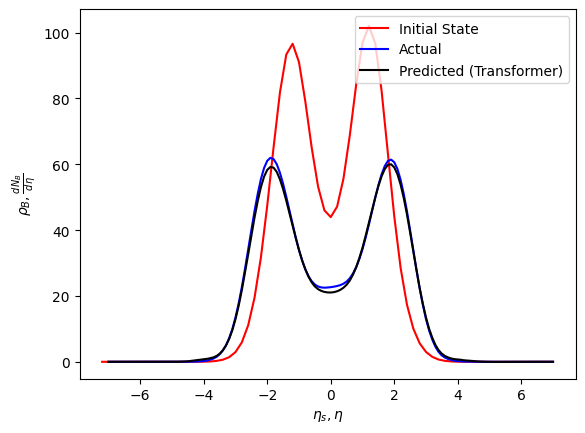

In [26]:
evaluate_model(model_tf_B, X_train_B, Y_train_B, sigma=1.5)

In [27]:
plot_error_norm_nn(model_tf, X_test_1, y_test_1, all_cent_test_1, all_charge_test_1)
plot_histograms_nn(model_tf, X_test_1, y_test_1, all_cent_test_1, all_charge_test_1)

NameError: name 'model_tf' is not defined

In [ ]:
model_path = 'tf_B.pth'

# Save model with state dictionary and other necessary information
torch.save({
    'input_dim': input_dim,
    'output_dim': output_dim,
    'model_state_dict': model_tf_B.state_dict()
}, model_path)
